In [21]:
import os
import re
import numpy as np
from numpy import exp
from matplotlib import pyplot as plt
from scipy import integrate

In [ ]:
input_dir = os.getcwd() + "/input/#4521-generated-sweep/"
-output_dir = os.getcwd() + "/output/less-noise/"
filenames = list(filter(lambda f: ".txt" in f, os.listdir(input_dir))) # Работаем только с .txt

def get_temp(filename):
    """Извлекаем температуру из имени файла."""
    return float(re.search(r"(?<=to-)\d+(?=K)", filename)[0])

In [23]:
def cut_range(data, startx, endx):
    """Ограничиваем диапазон"""
    xdata = data[:,0]
    if startx <= endx:
        condition = (startx <= xdata) & (xdata <= endx)
    else:
        condition = (startx > xdata) & (xdata > endx)
    return data[condition]

In [24]:
def find_closest(point, data):
    """Найти точку в массиве, ближайшую к заданной"""
    xdata = list(data[:,0])
    return np.where(data[:,0] == sorted(xdata, key=lambda x: abs(x-point))[0])[0][0]

def find_max(point, data, radius):
    """Найти локальный максимум рядом"""
    center = find_closest(point, data)
    return max(data[center-radius:center+radius,1])

In [25]:
hbar = 1.055 * 10**(-34)                                                                                  # J*s
k = 1.381 * 10**(-23) # J/K
c = 3 * 10**10 # cm/s
omega_laser = 1/633 * 10**7 # cm^-1

def B_factor1(omega, T):
    """Boltzman factor."""
    return 1 - exp(-hbar*omega*c/(k*T))

def B_factor2(omega, T):
    """Boltzman factor."""
    n = 1/(exp(hbar*omega*c/(k*T)) - 1)
    return 1/(n + 1)

def reduced_spectrum(omega, I, T):
    """Calculate reduced Raman spectrum for Stokes scattering."""
    wavelength_correction = (1 - omega/omega_laser)**(-4) # -omega for Stokes scattering.
    return wavelength_correction * omega * B_factor2(omega, T) * I

def reduced_spectrum_but_weird(omega, I):
    wavelength_correction = (1 - omega/omega_laser)**(-4) # -omega for Stokes scattering.
    return wavelength_correction * omega * I

def transform_spectrum_temp(omega, I, T1, T2, B_factor=B_factor2):
    """Transform spectrum at temperature T1 into one expected at T2."""
    ratio = B_factor(omega, T1) / B_factor(omega, T2)
    return I * ratio

In [26]:
def normalization_ratio(target, source, point, radius=10):
    return find_max(point, target, radius) / find_max(point, source, radius)

#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-100K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-10K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-120K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-140K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-15K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-160K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-180K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transformed-to-200K.txt
#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm-transform

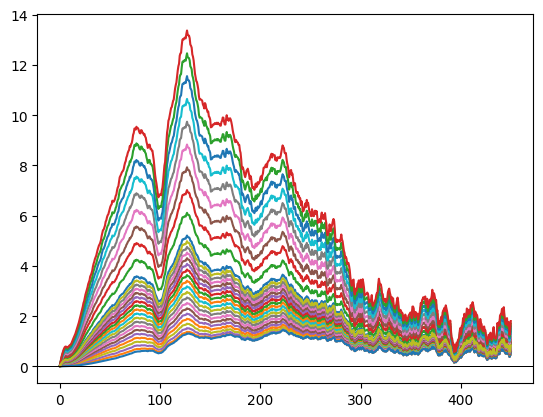

In [27]:
count = 0
for filename in filenames:
    count += 1
    if count != 5:
        2 == 2
        # continue

    T = get_temp(filename) # K
    # print(T)
    data = cut_range(np.loadtxt(input_dir + filename), 0, np.inf)
    background = np.mean(data[0:100,1])
    data = cut_range(np.loadtxt(input_dir + filename), 0, 450)
    data[:,1] = data[:,1] - background

    R = reduced_spectrum_but_weird(data[:,0], data[:,1])

    new_data = np.transpose(np.array([data[:,0], R]))
    new_data[:,1] = new_data[:,1] * normalization_ratio(data, new_data, 125)
    plt.plot(*np.transpose(new_data))

    plt.axhline(y=0, color='black', linewidth=0.7)
    
    print(filename)
    np.savetxt(output_dir + filename.split('.txt')[0] + "-reduced.txt", new_data)

In [28]:
%%script false --no-raise-error
T1 = 300 # K
#T2 = 5 # K

input_dir = os.getcwd() + "/input/#4521-R-Tdep-smoothed/"
filename = "#4521 (no ann)-p1-3-P 12mWx3.2__5x30 s_633nm_ULF_600 (500nm)_x50NIR(LWD)_H 100-T 25oC-sm.txt"
data = cut_range(np.loadtxt(input_dir + filename),0, np.inf)
X = data[:,0]
background = np.mean(data[0:100,1])
Y = data[:,1] - background

for T2 in range(120, 301, 20):
    Y_transformed = transform_spectrum_temp(X, Y, T1, T2, B_factor=B_factor1)
    plt.plot(X, Y, label=f"{T1} K")
    plt.plot(X, Y_transformed, label=f"{T2} K")
    new_data = np.array(np.transpose([X, Y_transformed]))
    np.savetxt(output_dir + filename.split('.txt')[0] + f"-transformed-to-{T2}K.txt", new_data)

plt.axhline(y=0, color='black', linewidth=0.7)
plt.legend()

Couldn't find program: 'false'
